<a href="https://colab.research.google.com/github/lucianetedesco/predicting-demand-for-bicycle-rentals/blob/main/predicting_demand_for_bicycle_rentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Referência: https://minerandodados.com.br/prevendo-a-demanda-de-alugueis-de-bicicletas-com-machine-learning/

# Prevendo a Demanda de Alugueis de Bicicletas


---


Os sistemas de compartilhamento de bicicletas são a nova geração de aluguel de bicicletas tradicionais, onde todo o processo de associação, aluguel e devolução se tornou automático.

Através desses sistemas, o usuário pode alugar facilmente uma bicicleta de uma posição específica e retornar para outra posição.

Atualmente, existem cerca de 500 programas de compartilhamento de bicicletas em todo o mundo, compostos por mais de 500 mil bicicletas.

Hoje, existe um grande interesse nesses sistemas devido ao seu importante papel nos problemas de tráfego, ambientais e de saúde.

Ao contrário de outros serviços de transporte, como ônibus ou metrô, a duração da viagem, a partida e a posição de chegada são explicitamente registradas nesses sistemas.

O objetivo é testar diferentes tipos de algoritmos de regressão para prever a quantidade de bicicletas alugadas.

## Importando as bibliotecas:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Carregando e visualizando a base de dados:

In [ ]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Entendendo a base de dados:
* **instant**: índice de registro
* **dteday**: data do aluguel (ano-mês-dia)
* **season**: estação (1: inverno, 2: primavera, 3: verão, 4: outono)
* **yr**: ano (0: 2011, 1: 2012)
* **mnth**: mês (1 a 12)
* **hr**: hora (0 a 23)
* **holiday**: o dia é feriado ou não (extraído de [holiday schedule](http://dchr.dc.gov/page/holiday-schedule))
* **weekday**: dia da semana
* **workingday**: se o dia não for final de semana nem feriado, então será 1, caso contrário será 0 – equivalente ao dia útil.
* **weathersit**: tempo
  * 1: limpo, poucas nuvens, parcialmente nublado
  * 2: névoa + nublado, névoa + nuvens partidas, névoa + poucas nuvens, névoa
  * 3: neve fraca, chuva fraca + trovoada + nuvens dispersas, chuva fraca + nuvens dispersas
  * 4: chuva forte + paletes de gelo + trovoada + névoa, neve + nevoeiro
* **temp**: temperatura normalizada em graus Celsius. Os valores são divididos em 41 (máximo)
* **atemp**: sensação de temperatura normalizada em graus Celsius. Os valores são divididos em 50 (máximo)
* **hum**: umidade normalizada. Os valores são divididos em 100 (máximo)
* **windspeed**: velocidade do vento normalizada. Os valores são divididos em 67 (máximo)
* **casual**: número de usuários casuais
* **registered**: número de usuários registrados
* **cnt**: contagem do total de bicicletas alugadas, incluindo bicicletas casuais e registradas ***(variável target)***

## Informações estatísticas da nossa base:

In [ ]:
bike_rentals.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Distribuição do atributo cnt:

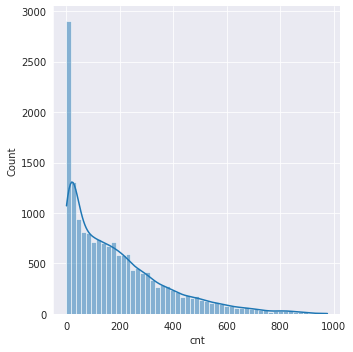

In [ ]:
sns.displot(bike_rentals.cnt, kde=True)

A distribuição dos dados dessa coluna está na faixa de 0 a 1000 com uma maior concentração entre as faixas de 0 a 200.

## Calculando a correlação entre as variáveis:

A intenção e saber o grau de correlação das variáveis com a variável que queremos prever(`cnt`), então podemos simplesmente filtrar a coluna com essas informações.

In [ ]:
correlations = bike_rentals.corr()
correlations['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Excluindo os atributos que são subcategorias do atributo alvo: casual, registered e do tipo date

Observe que `cnt` já inclui os valores de usuários casuais e registrados, então não faz sentindo manter essas 2 variáveis , pois esses dados são redundantes.

Também precisamos excluir a variável `dteday` que é do tipo date, os algoritmos de regressão não aceitam esse tipo de dado, e ela representa apenas a data do evento e não vai contribuir em nada para o modelo.

Na variável `columns` iremos guardar as nossas features, então precisamos excluir também a variável target (`cnt`).

In [ ]:
columns = bike_rentals.columns.drop(['cnt', 'casual', 'dteday', 'registered'])
columns

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

## Separando os dados de treino e teste:

Passamos as features que serão os dados de treino, a variável target e especificamos que 80% desses dados serão usados para treino e 20% para teste.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bike_rentals[columns],bike_rentals['cnt'], test_size=0.20, random_state=42)

Agora vamos começar a testar os nossos modelos, o primeiro deles será o de regressão linear que é o tipo mais básico.

# **Regressão Linear**

## Instanciando o algoritmo:

In [ ]:
lr = LinearRegression()

## Treinando o algoritmo e gerando o modelo de regressão:

In [ ]:
model = lr.fit(X_train,y_train)

resultado = model.predict(X_test)

Entregamos os dados do conjunto de teste para o modelo fazer a predição e guardamos os resultados na variável resultado.

## Calculando o erro médio quadrático:

In [ ]:
mean_squared_error(y_test, resultado)

19376.952766955474

O *mean_squared_error* é a diferença média quadrática entre o valor predito e o valor real, quanto menor for esse valor mais próximo o modelo está de acertar.

## Computando o Score:

In [ ]:
model.score(X_test,y_test)

0.3880719703569244

O valor dessa métrica varia entre 0 e 1, indicando em percentagem, o quanto o modelo consegue explicar os valores observados. Quanto maior esse valor , mais explicativo é o modelo.

## Comparando os resultados aplicando os dados de treinamento:

In [ ]:
resultado_treino = model.predict(X_train)
mean_squared_error(y_train, resultado_treino)

20292.141009176416

In [ ]:
model.score(X_train,y_train)

0.3888263676964571

Nesse primeiro modelo temos um erro muito alto e um valor de score muito baixo, esses resultados não são nem um pouco satisfatórios.

Um dos motivos é que temos muitos dados binários no conjunto de dados (0 e 1), os modelos de regressão linear tendem a funcionar melhor quando temos dados numéricos contínuos.

Os modelos de árvore apresentam melhores resultados, vamos ver a seguir se essa premissa se confirma.

# Árvore de Decisão

Vamos fazer os mesmos processos alterando apenas o tipo de modelo.

## Instanciando o algoritmo:

In [ ]:
tree = DecisionTreeRegressor()

## Treinando o algoritmo e gerando o modelo:

In [ ]:
model_tree = tree.fit(X_train,y_train)
resultado_tree = tree.predict(X_test)

## Calculando o erro médio quadrático:

In [ ]:
mean_squared_error(y_test, resultado_tree)

O valor de erro já diminuiu em comparação com o modelo anterior.

## Computando o Score:

In [ ]:
model_tree.score(X_test,y_test)

0.8935642077808191

Os resultados são bem melhores e já conseguimos cumprir o objetivo de diminuir o valor do erro e ter um score mais alto e validar a hipótese de que esse tipo de modelo tende a ser superior para o tipo de dado que estamos trabalhando.

# Random Forest

Apesar dos ótimos resultados que tivemos com a Árvore de Decisão o nosso modelo pode estar sofrendo *overfitting* (sobreajuste).

Os modelos *ensembles* como o Random Forest tem a missão de resolver esse tipo de problema e por isso apresentam resultados ainda mais satisfatórios.

Seu funcionamento é bem simples, ele usa várias Árvores de Decisão e pega o valor que cada uma das árvores, o resultado final vai ser o valor médio dessas árvores.

## Instanciando o algoritmo:

In [ ]:
tree_rf = RandomForestRegressor()

## Treinando o algoritmo e gerando o modelo:

In [ ]:
model_rf = tree_rf.fit(X_train, y_train)
resultado_rf = model_rf.predict(X_test)

## Calculando o erro médio quadrático:

In [ ]:
mean_squared_error(y_test, resultado_rf)

1633.2349533659378

## Computando o Score:

In [ ]:
model_rf.score(X_test,y_test)

0.9484221147165212

Excelente não acha? Como já esperávamos os resultados são ainda mais surpreendentes.

## Ajustando os hiperparametros do Random Forest:

Todos os modelos testados até o momento foram instanciados na sua forma mais básica sem nenhum ajuste de parâmetro.

Já temos o modelo que apresenta os melhores resultados e agora a meta e tentar encontrar os melhores parâmetros.

## Especificando os parâmetros de tunning:

In [ ]:
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]}

O **min_samples_leaf** é o número mínimo de amostras necessárias para estar em um nó folha.

O **min_samples_split** é o número mínimo de amostras necessárias para dividir um nó interno.

E o **n_estimators** é o número de árvores que será gerada.

## Instanciando o RandomForest e GridSearch:

In [ ]:
rf = RandomForestRegressor()
grid = GridSearchCV(rf, parametros)

Para o grid passamos o modelo e os parâmetros que definimos para que ele faça os testes exaustivos.

## Executando o grid:

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

## Verificando os melhores parâmetros:

In [ ]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750}

Essa é a melhor configuração que ele encontrou.

## Recuperando o melhor estimator:

In [ ]:
rf_best = grid.best_estimator_

## Gerando o resultado final:

In [ ]:
resultado_final = rf_best.predict(X_test)

Utilizamos os melhores parâmetros encontrados para fazer a predição.

## Calculando o erro médio quadrático:

In [ ]:
mean_squared_error(y_test, resultado_final)

1630.7031259966755

O erro foi ainda menor que o anterior que era de aproximadamente 1680.

## Computando o Score:

In [ ]:
rf_best.score(X_test,y_test)

0.9485020703293618

Esse é o score do nosso modelo final, uma grande evolução nos resultados.